In [1]:
# !pip install matplotlib
# !pip install gurobipy
# !pip install torch_geometric

In [2]:
# !pip install scikit-learn

In [3]:
import gurobipy as gp
from gurobipy import GRB
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader  # Corrected import
from torch_geometric.nn import MessagePassing
from torch_geometric.nn import global_mean_pool  # For pooling in the decoder
from tqdm import tqdm
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import random
import matplotlib.pyplot as plt  # For plotting losses

In [4]:
from parse_QP import my_callback

In [5]:
# Read the problem
number = "0031"
grb_model = gp.read(f"QPLIB_{number}.lp")

# Solution storage
grb_model._feasible_solutions = []
grb_model._relaxation_solutions = []
grb_model.setParam("MIPGap", 0.05)
#model.setParam("NodeLimit", 100)  # Explore a limited number of nodes

# Optimize
grb_model.optimize(my_callback)

Set parameter Username
Academic license - for non-commercial use only - expires 2025-11-27
Read LP format model from file QPLIB_0031.lp
Reading time = 0.00 seconds
obj: 32 rows, 60 columns, 120 nonzeros
Set parameter MIPGap to value 0.05
Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M1 Max
Thread count: 10 physical cores, 10 logical processors, using up to 10 threads

Non-default parameters:
MIPGap  0.05

Optimize a model with 32 rows, 60 columns and 120 nonzeros
Model fingerprint: 0x00d24133
Model has 464 quadratic objective terms
Variable types: 30 continuous, 30 integer (30 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [0e+00, 0e+00]
  QObjective range [3e+01, 2e+04]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 5e+00]
Found heuristic solution: objective 3654.4800000
Presolve time: 0.01s
Presolved: 901 rows, 526 columns, 2321 nonzeros
Presolved model has 30 quadratic constra

In [6]:
# Retrieve optimal solution if available
if grb_model.status == GRB.OPTIMAL:
    optimal_solution = grb_model.getAttr('X', grb_model.getVars())
    print("Optimal solution:", optimal_solution)
else:
    print(f"Model status: {grb_model.status}")

Optimal solution: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.1943116520814998, 0.23803709013973667, 0.0, 0.23883491747424568, 0.0, 0.0, 0.13439630213611006, 0.19442003816840775, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.0, 1.0, 1.0, 0.0, 1.0, -0.0, 0.0, 1.0, 1.0, 0.0, -0.0, -0.0, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0]


In [7]:
# Define a maximum finite bound for replacing infinities
max_finite_bound = 1e5

# Extract bounds and handle infinities
variable_bounds = {}
for var in grb_model.getVars():
    lower_bound = var.LB
    upper_bound = var.UB
    
    # Replace infinite bounds with finite values
    if lower_bound == float('-inf'):
        lower_bound = -max_finite_bound
    if upper_bound == float('inf'):
        upper_bound = max_finite_bound
    
    variable_bounds[var.VarName] = {'Lower': lower_bound, 'Upper': upper_bound}


In [8]:
## Extracting Q, A, b, d, etc

from parse_QP import parse_qplib_file

# Replace '0031' with the desired file number
data = parse_qplib_file('0031')

# Access the data
A = data['A']
b_vector = data['b_vector']
E = data['E']
d_vector = data['d']
Q = data['Q']
variables_info = data['variables_info']
variables_info = [v[0] for v in variables_info]
binary_indices = data['binary_indices']
variable_indices = data['variable_indices']

m, n = A.shape
# Get indices of non-zero elements in A
row_indices, col_indices = np.nonzero(A)
edge_weights = A[row_indices, col_indices]

# Map variable types to numerical values
# Node types: 0 - continuous, 1 - binary
variable_types = np.array([0 if v[0] == 'x' else 1 for v in variables_info])

# Collect indices of continuous and binary variables
continuous_indices = np.where(variable_types == 0)[0]
binary_indices = np.where(variable_types == 1)[0]
n_continuous = len(continuous_indices)
n_binary = len(binary_indices)
n_variables = n_continuous + n_binary

In [9]:
variable_types_tensor = torch.tensor(variable_types)

In [10]:
variable_lower_bounds = torch.tensor([variable_bounds[var_name]['Lower'] for var_name in variable_bounds], dtype=torch.float)
variable_upper_bounds = torch.tensor([variable_bounds[var_name]['Upper'] for var_name in variable_bounds], dtype=torch.float)

# For binary variables, we ensure LB=0, UB=1
for i, vtype in enumerate(variable_types_tensor):
    if vtype == 1.0:
        variable_lower_bounds[i] = 0.0
        variable_upper_bounds[i] = 1.0


In [23]:
import os
import pickle
from generate_solutions import generate_feasible_solutions, generate_infeasible_solutions

# Set generate_new to False by default
generate_new = True
feasible_data_file = 'feasible_data.pkl'
infeasible_data_file = 'infeasible_data.pkl'
num_samples = 500

# Load or generate feasible solutions (as in your original code)
if not generate_new and os.path.exists(feasible_data_file):
    # Load feasible data
    with open(feasible_data_file, 'rb') as f:
        feasible_data = pickle.load(f)
    feasible_solutions = feasible_data['solutions']
    feasible_costs = feasible_data['costs']
    print("Loaded existing feasible solutions from file.")
else:
    # Generate feasible solutions
    num_objectives = num_samples  # Adjust the number as needed
    feasible_solutions, feasible_costs = generate_feasible_solutions(
        A, E, Q, variables_info, b_vector, d_vector, num_objectives
    )
    # Save the generated data for future use
    feasible_data = {'solutions': feasible_solutions, 'costs': feasible_costs}
    with open(feasible_data_file, 'wb') as f:
        pickle.dump(feasible_data, f)
    print("Generated and saved feasible solutions.")

# Now, load or generate infeasible solutions
if not generate_new and os.path.exists(infeasible_data_file):
    # Load infeasible data
    with open(infeasible_data_file, 'rb') as f:
        infeasible_data = pickle.load(f)
    infeasible_solutions = infeasible_data['solutions']
    infeasible_costs = infeasible_data['costs']
    print("Loaded existing infeasible solutions from file.")
else:
    # Generate infeasible solutions
    num_infeasible_samples = num_samples  # Adjust as needed
    infeasible_solutions, infeasible_costs = generate_infeasible_solutions(
        A, E, variables_info, b_vector, d_vector, Q, num_infeasible_samples, feasible_solutions
    )
    # Save the generated data for future use
    infeasible_data = {'solutions': infeasible_solutions, 'costs': infeasible_costs}
    with open(infeasible_data_file, 'wb') as f:
        pickle.dump(infeasible_data, f)
    print("Generated and saved infeasible solutions.")


Generating Feasible Solutions: 100%|██████████| 500/500 [00:48<00:00, 10.24it/s]


Generated and saved feasible solutions.
Generating infeasible samples...


Infeasible Samples: 100%|██████████| 500/500 [00:00<00:00, 4514.64it/s]

Generated and saved infeasible solutions.


In [43]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch_geometric.data import Data, DataLoader, Batch
from torch_geometric.nn import GCNConv, global_mean_pool
import numpy as np


# Data preparation functions
def prepare_edge_index_and_attr(Q):
    n_variables = Q.shape[0]
    edge_index = []
    edge_attr = []
    Q = Q if isinstance(Q, np.ndarray) else Q.toarray()
    for i in range(n_variables):
        for j in range(n_variables):
            if Q[i, j] != 0:
                edge_index.append([i, j])
                edge_attr.append(Q[i, j])
    edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
    edge_attr = torch.tensor(edge_attr, dtype=torch.float)
    return edge_index, edge_attr

def prepare_constraint_edge_data(A, E, n_variables):
    # A: m x n, E: p x n
    m = A.shape[0]
    p = E.shape[0]
    num_constraints = m + p
    edge_index = []
    edge_attr = []
    # Edges from variables to inequality constraints
    for constraint_idx in range(m):
        for variable_idx in range(n_variables):
            coeff = A[constraint_idx, variable_idx]
            if coeff != 0:
                # Edge from variable to constraint
                edge_index.append([variable_idx, n_variables + constraint_idx])
                edge_attr.append(coeff)
    # Edges from variables to equality constraints
    for constraint_idx in range(p):
        for variable_idx in range(n_variables):
            coeff = E[constraint_idx, variable_idx]
            if coeff != 0:
                # Edge from variable to constraint
                edge_index.append([variable_idx, n_variables + m + constraint_idx])
                edge_attr.append(coeff)
    edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
    edge_attr = torch.tensor(edge_attr, dtype=torch.float)
    return edge_index, edge_attr

def create_data_list_obj(solutions, costs, edge_index, edge_attr):
    data_list = []
    for x_sol, cost_sol in zip(solutions, costs):
        x_sol_tensor = torch.tensor(x_sol, dtype=torch.float)
        # Variable features: [x_value, variable_type, LB, UB]
        var_features = torch.stack([x_sol_tensor, variable_types_tensor, variable_lower_bounds, variable_upper_bounds], dim=1)
        data = Data(x=var_features, edge_index=edge_index, edge_attr=edge_attr)
        data.variable_mask = torch.ones(data.num_nodes, dtype=torch.bool)
        data.binary_mask = variable_types_tensor.bool()
        
        # y_x is just the x_value (we only predict x), so extract column 0
        data.y_x = x_sol_tensor  # Unnormalized target
        data.y_cost = torch.tensor([cost_sol], dtype=torch.float)
        data_list.append(data)
    return data_list


def create_data_list_feas(solutions, costs, A, E, b_vector, d_vector, edge_index, edge_attr, n_variables):
    data_list = []
    m = A.shape[0]
    p = E.shape[0]
    num_constraints = m + p
    for x_sol, cost_sol in zip(solutions, costs):
        x_sol_tensor = torch.tensor(x_sol, dtype=torch.float)
        var_features = torch.stack([x_sol_tensor, variable_types_tensor, variable_lower_bounds, variable_upper_bounds], dim=1)

        b = torch.tensor(b_vector, dtype=torch.float).unsqueeze(-1)
        d = torch.tensor(d_vector, dtype=torch.float).unsqueeze(-1)
        x_constraints = torch.cat([b, d], dim=0)

        x_constraints_padded = torch.nn.functional.pad(x_constraints, (0, var_features.shape[1] - x_constraints.shape[1]))
        x_total = torch.cat([var_features, x_constraints_padded], dim=0)

        data = Data(x=x_total, edge_index=edge_index, edge_attr=edge_attr)
        data.variable_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
        data.variable_mask[:n_variables] = True
        data.binary_mask = variable_types_tensor.bool()

        data.y_x = x_sol_tensor  # Unnormalized
        data.y_cost = torch.tensor([cost_sol], dtype=torch.float)

        # Compute constraint violations as before
        A_tensor = torch.tensor(A, dtype=torch.float)
        E_tensor = torch.tensor(E, dtype=torch.float)
        inequality_violations = torch.mv(A_tensor, x_sol_tensor) - torch.tensor(b_vector, dtype=torch.float)
        equality_violations = torch.mv(E_tensor, x_sol_tensor) - torch.tensor(d_vector, dtype=torch.float)
        y_constraints = torch.cat([inequality_violations, equality_violations], dim=0)
        data.y_constraints = y_constraints
        data_list.append(data)
    return data_list


def normalize_node_features(data_list):
    """
    Normalize node features for continuous variables and constraints separately.
    
    Args:
        data_list: List of graph data objects (torch_geometric.data.Data).

    Returns:
        Normalized data_list, means, and stds for continuous variables and constraints.
    """
    # Initialize storage for global statistics
    means = {"continuous": None, "constraints": None}
    stds = {"continuous": None, "constraints": None}

    # Collect features for continuous variables and constraints
    all_continuous_features = []
    all_constraint_features = []

    # Collect features across all graphs
    for data in data_list:
        # Extract masks
        var_mask = data.variable_mask
        binary_mask = data.binary_mask

        # Continuous variables: Variables not marked as binary
        variable_features = data.x[var_mask]
        continuous_features = variable_features[~binary_mask]  # Exclude binary variables

        # Constraint features: Nodes not marked as variables
        constraint_features = data.x[~var_mask]

        # Append to global collections
        all_continuous_features.append(continuous_features)
        all_constraint_features.append(constraint_features)

    # Concatenate features to compute global statistics
    all_continuous_features = torch.cat(all_continuous_features, dim=0)
    all_constraint_features = torch.cat(all_constraint_features, dim=0)

    # Compute means and stds for continuous variables
    means["continuous"] = all_continuous_features.mean(dim=0)
    stds["continuous"] = all_continuous_features.std(dim=0) + 1e-6  # Avoid division by zero

    # Compute means and stds for constraints
    means["constraints"] = all_constraint_features.mean(dim=0)
    stds["constraints"] = all_constraint_features.std(dim=0) + 1e-6

    # Apply normalization to each graph
    for data in data_list:
        # Continuous variables
        variable_features = data.x[data.variable_mask]
        continuous_features = variable_features[~data.binary_mask]
        variable_features[~data.binary_mask] = (
            continuous_features - means["continuous"]
        ) / stds["continuous"]
        data.x[data.variable_mask] = variable_features

        # Constraints
        data.x[~data.variable_mask] = (
            data.x[~data.variable_mask] - means["constraints"]
        ) / stds["constraints"]

    return data_list, means, stds

def normalize_targets(data_list):

    # Normalize y_x (node targets) - exclude binary variables
    y_x_all = []
    for data in data_list:
        # Exclude binary variables from y_x normalization
        continuous_targets = data.y_x[~data.binary_mask]  # Only continuous targets
        y_x_all.append(continuous_targets)

    y_x_all = torch.cat(y_x_all, dim=0)
    mean_y_x = y_x_all.mean()
    std_y_x = y_x_all.std() + 1e-6  # Avoid division by zero

    for data in data_list:
        continuous_targets = data.y_x[~data.binary_mask]
        data.y_x[~data.binary_mask] = (continuous_targets - mean_y_x) / std_y_x

    # Normalize y_cost (graph targets)
    y_cost_all = torch.cat([data.y_cost for data in data_list], dim=0)
    mean_y_cost = y_cost_all.mean()
    std_y_cost = y_cost_all.std() + 1e-6

    for data in data_list:
        data.y_cost = (data.y_cost - mean_y_cost) / std_y_cost

    # Normalize y_constraints (if present)
    mean_y_constraints = None
    std_y_constraints = None
    if hasattr(data_list[0], 'y_constraints'):
        y_constraints_all = torch.cat([data.y_constraints for data in data_list], dim=0)
        mean_y_constraints = y_constraints_all.mean()
        std_y_constraints = y_constraints_all.std() + 1e-6
        for data in data_list:
            data.y_constraints = (data.y_constraints - mean_y_constraints) / std_y_constraints

    return data_list, (mean_y_x, std_y_x), (mean_y_cost, std_y_cost), (mean_y_constraints, std_y_constraints)


def split_data(data_list, test_size=0.2, random_state=42):
    np.random.seed(random_state)
    indices = np.random.permutation(len(data_list))
    test_set_size = int(len(data_list) * test_size)
    test_indices = indices[:test_set_size]
    train_indices = indices[test_set_size:]
    train_data = [data_list[i] for i in train_indices]
    test_data = [data_list[i] for i in test_indices]
    return train_data, test_data

# Assume you have the following variables defined:
# Q, A, E, b_vector, d_vector, feasible_solutions, feasible_costs, infeasible_solutions, infeasible_costs, n_variables

# Prepare edge information from Q
edge_index_obj, edge_attr_obj = prepare_edge_index_and_attr(Q)

# Prepare edge information from A and E
edge_index_feas, edge_attr_feas = prepare_constraint_edge_data(A, E, n_variables)

# Create Data objects for feasible solutions
data_list_obj_feas = create_data_list_obj(feasible_solutions, feasible_costs, edge_index_obj, edge_attr_obj)
data_list_feas_feas = create_data_list_feas(feasible_solutions, feasible_costs, A, E, b_vector, d_vector, edge_index_feas, edge_attr_feas, n_variables)

# Create Data objects for infeasible solutions
data_list_obj_infeas = create_data_list_obj(infeasible_solutions, infeasible_costs, edge_index_obj, edge_attr_obj)
data_list_feas_infeas = create_data_list_feas(infeasible_solutions, infeasible_costs, A, E, b_vector, d_vector, edge_index_feas, edge_attr_feas, n_variables)

# Combine feasible and infeasible data
data_list_obj = data_list_obj_feas # + data_list_obj_infeas
data_list_feas = data_list_feas_feas # + data_list_feas_infeas

In [46]:
# Normalize node features for data_list_obj
data_list_obj, mean_obj, std_obj = normalize_node_features(data_list_obj)

# Normalize node features for data_list_feas
data_list_feas, mean_feas, std_feas = normalize_node_features(data_list_feas)

# Normalize targets (x and cost) for data_list_obj
data_list_obj, (mean_y_x, std_y_x), (mean_y_cost, std_y_cost), _ = normalize_targets(data_list_obj)

# Normalize targets (x, cost, and constraints) for data_list_feas
data_list_feas, _, _, (mean_y_constraints, std_y_constraints) = normalize_targets(data_list_feas)

# Split into train and test sets
train_data_obj, test_data_obj = split_data(data_list_obj, test_size=0.2, random_state=42)
train_data_feas, test_data_feas = split_data(data_list_feas, test_size=0.2, random_state=42)

/var/folders/g1/cbg0y1nj55v4p3lfbkx_dcdh0000gn/T/ipykernel_92999/2589294698.py:149: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/ReduceOps.cpp:1823.)
  stds["constraints"] = all_constraint_features.std(dim=0) + 1e-6


In [49]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch_geometric.data import Data, DataLoader, Batch
from torch_geometric.nn import GCNConv, global_mean_pool
import numpy as np

# Adjusted GNNModelObj to output variable node embeddings
class GNNModelObj(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GNNModelObj, self).__init__()
        self.conv1 = GCNConv(4, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)

    def forward(self, data):
        x, edge_index, edge_weight = data.x, data.edge_index, data.edge_attr
        x = F.relu(self.conv1(x, edge_index, edge_weight=edge_weight))
        x = F.relu(self.conv2(x, edge_index, edge_weight=edge_weight))
        return x  # Return embeddings for all variable nodes

# Adjusted GNNModelConstraints to output variable and constraint node embeddings
class GNNModelConstraints(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GNNModelConstraints, self).__init__()
        self.conv1 = GCNConv(4, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)

    def forward(self, data):
        x, edge_index, edge_weight = data.x, data.edge_index, data.edge_attr
        x = F.relu(self.conv1(x, edge_index, edge_weight=edge_weight))
        x = F.relu(self.conv2(x, edge_index, edge_weight=edge_weight))
        x_var = x[data.variable_mask]
        x_constraints = x[~data.variable_mask]
        return x_var, x_constraints  # Return embeddings for both variables and constraints

# Define the JointGNN model
class JointGNN(torch.nn.Module):
    def __init__(self, hidden_channels_obj, hidden_channels_cons, decoder_hidden_channels):
        super(JointGNN, self).__init__()
        # Encoders
        self.encoder_obj = GNNModelObj(hidden_channels_obj)
        self.encoder_cons = GNNModelConstraints(hidden_channels_cons)
        # Decoder for x reconstruction
        concat_dim = hidden_channels_obj + hidden_channels_cons
        self.decoder_x = torch.nn.Sequential(
            torch.nn.Linear(concat_dim, decoder_hidden_channels),
            torch.nn.ReLU(),
            torch.nn.Linear(decoder_hidden_channels, 1)
        )
        # Decoder for cost prediction
        self.decoder_cost = torch.nn.Sequential(
            torch.nn.Linear(concat_dim, decoder_hidden_channels),
            torch.nn.ReLU(),
            torch.nn.Linear(decoder_hidden_channels, 1)
        )
        # Decoder for constraint violation prediction
        self.decoder_constraints = torch.nn.Sequential(
            torch.nn.Linear(hidden_channels_cons, decoder_hidden_channels),
            torch.nn.ReLU(),
            torch.nn.Linear(decoder_hidden_channels, 1)
        )

    def forward(self, data_obj, data_feas):
        # Process data through encoders
        x_obj = self.encoder_obj(data_obj)  # Embeddings for variables
        x_cons_var, x_cons_constraints = self.encoder_cons(data_feas)  # Embeddings for variables and constraints
        # Extract variable embeddings
        x_obj_var = x_obj[data_obj.variable_mask]
        # Concatenate per-variable embeddings
        x_var = torch.cat([x_obj_var, x_cons_var], dim=1)
        # Decode to reconstruct x
        x_hat = self.decoder_x(x_var).squeeze()
        # Compute mean pooling over variable nodes for cost prediction
        batch = data_obj.batch[data_obj.variable_mask]
        x_var_pooled = global_mean_pool(x_var, batch)  # [batch_size, concat_dim]
        # Predict cost
        predicted_cost = self.decoder_cost(x_var_pooled).squeeze()
        # Decode to predict constraint violations
        predicted_constraints = self.decoder_constraints(x_cons_constraints).squeeze()
        return x_hat, predicted_cost, predicted_constraints

# Custom dataset to return pairs of data_obj and data_feas
class JointDataset(Dataset):
    def __init__(self, data_list_obj, data_list_feas):
        assert len(data_list_obj) == len(data_list_feas)
        self.data_list_obj = data_list_obj
        self.data_list_feas = data_list_feas

    def __len__(self):
        return len(self.data_list_obj)

    def __getitem__(self, idx):
        return self.data_list_obj[idx], self.data_list_feas[idx]

# Custom collate function for batching
def joint_collate_fn(batch):
    data_obj_list, data_feas_list = zip(*batch)
    batch_obj = Batch.from_data_list(data_obj_list)
    batch_feas = Batch.from_data_list(data_feas_list)
    return batch_obj, batch_feas

In [50]:
# Create datasets and data loaders
train_dataset = JointDataset(train_data_obj, train_data_feas)
test_dataset = JointDataset(test_data_obj, test_data_feas)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=joint_collate_fn)
test_loader = DataLoader(test_dataset, batch_size=32, collate_fn=joint_collate_fn)

# Initialize model, optimizer, and loss function
model = JointGNN(hidden_channels_obj=256, hidden_channels_cons=128, decoder_hidden_channels=64)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.MSELoss()

# Training and testing functions
def train():
    model.train()
    total_loss = 0
    total_recon_loss = 0
    total_cost_loss = 0
    total_constraint_loss = 0
    total_original_cost_loss = 0
    total_original_constraint_loss = 0
    for data_obj_batch, data_feas_batch in train_loader:
        optimizer.zero_grad()
        x_hat, predicted_cost, predicted_constraints = model(data_obj_batch, data_feas_batch)
        

        # Get target x values and cost values
        y_x = data_obj_batch.y_x
        y_cost = data_obj_batch.y_cost.squeeze()
        y_constraints = data_feas_batch.y_constraints
        # Compute reconstruction loss
        recon_loss = criterion(x_hat, y_x)
        # Compute cost prediction loss
        cost_loss = criterion(predicted_cost, y_cost)
        # Compute constraint violation loss
        constraint_loss = criterion(predicted_constraints, y_constraints)
        # Total loss (weighted sum)
        loss = recon_loss + cost_loss + constraint_loss  # You can adjust weights if desired
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * data_obj_batch.num_graphs
        total_recon_loss += recon_loss.item() * data_obj_batch.num_graphs
        total_cost_loss += cost_loss.item() * data_obj_batch.num_graphs
        total_constraint_loss += constraint_loss.item() * data_obj_batch.num_graphs

        # Compute original cost loss (denormalized)
        predicted_cost_orig = predicted_cost * std_y_cost + mean_y_cost
        y_cost_orig = y_cost * std_y_cost + mean_y_cost
        original_cost_loss = criterion(predicted_cost_orig, y_cost_orig)
        total_original_cost_loss += original_cost_loss.item() * data_obj_batch.num_graphs

        # Compute original constraint loss (denormalized)
        predicted_constraints_orig = predicted_constraints * std_y_constraints + mean_y_constraints
        y_constraints_orig = y_constraints * std_y_constraints + mean_y_constraints
        original_constraint_loss = criterion(predicted_constraints_orig, y_constraints_orig)
        total_original_constraint_loss += original_constraint_loss.item() * data_obj_batch.num_graphs

    avg_loss = total_loss / len(train_loader.dataset)
    avg_recon_loss = total_recon_loss / len(train_loader.dataset)
    avg_cost_loss = total_cost_loss / len(train_loader.dataset)
    avg_constraint_loss = total_constraint_loss / len(train_loader.dataset)
    avg_original_cost_loss = total_original_cost_loss / len(train_loader.dataset)
    avg_original_constraint_loss = total_original_constraint_loss / len(train_loader.dataset)
    return avg_loss, avg_recon_loss, avg_cost_loss, avg_constraint_loss, avg_original_cost_loss, avg_original_constraint_loss

def test(loader):
    model.eval()
    total_loss = 0
    total_recon_loss = 0
    total_cost_loss = 0
    total_constraint_loss = 0
    total_original_cost_loss = 0
    total_original_constraint_loss = 0
    with torch.no_grad():
        for data_obj_batch, data_feas_batch in loader:
            x_hat, predicted_cost, predicted_constraints = model(data_obj_batch, data_feas_batch)
            y_x = data_obj_batch.y_x
            y_cost = data_obj_batch.y_cost.squeeze()
            y_constraints = data_feas_batch.y_constraints
            recon_loss = criterion(x_hat, y_x)
            cost_loss = criterion(predicted_cost, y_cost)
            constraint_loss = criterion(predicted_constraints, y_constraints)
            loss = recon_loss + cost_loss + constraint_loss
            total_loss += loss.item() * data_obj_batch.num_graphs
            total_recon_loss += recon_loss.item() * data_obj_batch.num_graphs
            total_cost_loss += cost_loss.item() * data_obj_batch.num_graphs
            total_constraint_loss += constraint_loss.item() * data_obj_batch.num_graphs

            # Compute original cost loss (denormalized)
            predicted_cost_orig = predicted_cost * std_y_cost + mean_y_cost
            y_cost_orig = y_cost * std_y_cost + mean_y_cost
            original_cost_loss = criterion(predicted_cost_orig, y_cost_orig)
            total_original_cost_loss += original_cost_loss.item() * data_obj_batch.num_graphs

            # Compute original constraint loss (denormalized)
            predicted_constraints_orig = predicted_constraints * std_y_constraints + mean_y_constraints
            y_constraints_orig = y_constraints * std_y_constraints + mean_y_constraints
            original_constraint_loss = criterion(predicted_constraints_orig, y_constraints_orig)
            total_original_constraint_loss += original_constraint_loss.item() * data_obj_batch.num_graphs

    avg_loss = total_loss / len(loader.dataset)
    avg_recon_loss = total_recon_loss / len(loader.dataset)
    avg_cost_loss = total_cost_loss / len(loader.dataset)
    avg_constraint_loss = total_constraint_loss / len(loader.dataset)
    avg_original_cost_loss = total_original_cost_loss / len(loader.dataset)
    avg_original_constraint_loss = total_original_constraint_loss / len(loader.dataset)
    return avg_loss, avg_recon_loss, avg_cost_loss, avg_constraint_loss, avg_original_cost_loss, avg_original_constraint_loss

# Training loop
num_epochs = 50
test_loss, test_recon_loss, test_cost_loss, test_constraint_loss, test_orig_cost_loss, test_orig_constraint_loss = test(test_loader)

print(f"Pre-Test Loss: {test_loss:.4f}, Recon Loss: {test_recon_loss:.4f}, "
      f"Cost Loss: {test_cost_loss:.4f}, Constraint Loss: {test_constraint_loss:.4f}")

for epoch in range(1, num_epochs + 1):
    # Unpack all six returned values
    train_loss, train_recon_loss, train_cost_loss, train_constraint_loss, train_orig_cost_loss, train_orig_constraint_loss = train()
    test_loss, test_recon_loss, test_cost_loss, test_constraint_loss, test_orig_cost_loss, test_orig_constraint_loss = test(test_loader)

    print("----")
    # Print out all the losses
    print(f"Epoch {epoch}, Train Loss: {train_loss:.4f}, Recon Loss: {train_recon_loss:.4f}, "
          f"Cost Loss: {train_cost_loss:.4f}, Constraint Loss: {train_constraint_loss:.4f}")
    print(f"Test Loss: {test_loss:.4f}, Recon Loss: {test_recon_loss:.4f}, "
          f"Cost Loss: {test_cost_loss:.4f}, Constraint Loss: {test_constraint_loss:.4f}")
    print("----")


Pre-Test Loss: 2.7476, Recon Loss: 0.5442, Cost Loss: 1.1091, Constraint Loss: 1.0944
----
Epoch 1, Train Loss: 2.3513, Recon Loss: 0.4741, Cost Loss: 0.9707, Constraint Loss: 0.9065
Test Loss: 2.3258, Recon Loss: 0.4219, Cost Loss: 1.0966, Constraint Loss: 0.8073
----
----
Epoch 2, Train Loss: 1.9963, Recon Loss: 0.3551, Cost Loss: 0.9696, Constraint Loss: 0.6716
Test Loss: 1.9515, Recon Loss: 0.2807, Cost Loss: 1.0902, Constraint Loss: 0.5805
----
----
Epoch 3, Train Loss: 1.5970, Recon Loss: 0.2024, Cost Loss: 0.9623, Constraint Loss: 0.4324
Test Loss: 1.5096, Recon Loss: 0.1125, Cost Loss: 1.0871, Constraint Loss: 0.3099
----
----
Epoch 4, Train Loss: 1.2091, Recon Loss: 0.0619, Cost Loss: 0.9563, Constraint Loss: 0.1909
Test Loss: 1.1863, Recon Loss: 0.0141, Cost Loss: 1.0729, Constraint Loss: 0.0992
----
----
Epoch 5, Train Loss: 1.0309, Recon Loss: 0.0108, Cost Loss: 0.9421, Constraint Loss: 0.0779
Test Loss: 1.1482, Recon Loss: 0.0146, Cost Loss: 1.0584, Constraint Loss: 0.0752

In [ ]:
data_list_feas_feas = create_data_list_feas(feasible_solutions, feasible_costs, A, E, b_vector, d_vector, edge_index_feas, edge_attr_feas, n_variables)

In [159]:
# Use a batch of data
data_obj_batch, data_feas_batch = next(iter(test_loader))
with torch.no_grad():
    # Encode and decode
    z_obj = model.encoder_obj(data_obj_batch)
    z_cons_var, z_constraints = model.encoder_cons(data_feas_batch)
    x_obj_var = z_obj[data_obj_batch.variable_mask]
    x_var = torch.cat([x_obj_var, z_cons_var], dim=1)
    x_hat = model.decoder_x(x_var).squeeze()
    # Denormalize x_hat and y_x
    x_hat_denorm = x_hat * std_y_x + mean_y_x
    y_x_denorm = data_obj_batch.y_x * std_y_x + mean_y_x
    # Compute reconstruction error
    recon_error = torch.norm(x_hat_denorm - y_x_denorm)
    print(f"Decoder Reconstruction Error: {recon_error.item()}")


Decoder Reconstruction Error: 0.0298283901065588


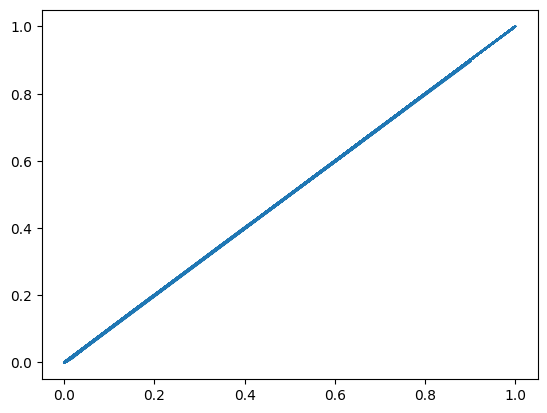

In [160]:
plt.plot(y_x_denorm.cpu().numpy(), np.round(x_hat_denorm, 3).cpu().numpy())

In [161]:
def evaluate_predictions(model, data_list_obj, data_list_feas):
    model.eval()
    actual_costs = []
    predicted_costs = []
    actual_constraints = []
    predicted_constraints_list = []  # Renamed the list
    with torch.no_grad():
        for data_obj, data_feas in zip(data_list_obj, data_list_feas):
            # Get the true x
            y_x = data_obj.y_x * std_y_x + mean_y_x  # [n_variables]
            y_x_np = y_x.detach().numpy()  # Shape: (n_variables,)
            # Compute actual cost
            actual_cost = 0.5 * y_x_np.T @ Q @ y_x_np  # Scalar
            actual_costs.append(actual_cost)
            # Compute actual constraint violations
            inequality_violations = A @ y_x_np - b_vector  # Shape: (num_inequality_constraints,)
            equality_violations = E @ y_x_np - d_vector    # Shape: (num_equality_constraints,)

            actual_constraint = np.concatenate((inequality_violations, equality_violations))  # Shape: (num_constraints,)
            actual_constraints.extend(actual_constraint)
            # Get model predictions
            # Prepare batch data for model input
            data_obj_batch = Batch.from_data_list([data_obj])
            data_feas_batch = Batch.from_data_list([data_feas])
            x_hat, predicted_cost, predicted_constraints = model(data_obj_batch, data_feas_batch)
            # Denormalize predicted cost and constraints
            predicted_cost_denorm = (predicted_cost.item() * std_y_cost + mean_y_cost)
            predicted_constraints_denorm = (predicted_constraints * std_y_constraints + mean_y_constraints).detach().numpy()
            predicted_costs.append(predicted_cost_denorm)
            predicted_constraints_list.extend(predicted_constraints_denorm)  # Use the renamed list
            
            print(equality_violations)
            print("Ineq:",inequality_violations)
            print(predicted_constraints_denorm)

    # Compute correlations
    cost_correlation = np.corrcoef(actual_costs, predicted_costs)[0,1]
    constraint_correlation = np.corrcoef(np.array(actual_constraints), np.array(predicted_constraints_list))[0,1]
    print(f"Cost Prediction Correlation: {cost_correlation}")
    print(f"Constraint Prediction Correlation: {constraint_correlation}")


In [162]:
# Assuming you have test_data_obj and test_data_feas
evaluate_predictions(model, test_data_obj, test_data_feas)

[0.97834999]
Ineq: [-3.00000010e+00  7.36800022e-02  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  5.88600039e-02  0.00000000e+00
  2.27600038e-02  7.10006803e-04  2.14810003e-01  0.00000000e+00
  0.00000000e+00  4.00000028e-02  1.22600049e-02  5.39400019e-02
  1.53230000e-01  0.00000000e+00  1.36370007e-01 -6.04869962e-01
  0.00000000e+00  8.07800032e-02  0.00000000e+00  0.00000000e+00
  0.00000000e+00  5.86400032e-02 -4.90999997e-01  0.00000000e+00
  0.00000000e+00  0.00000000e+00  1.68180007e-01]
[-3.0359466   0.07417326  0.00363409  0.00363409  0.00363409  0.00363409
  0.05784023  0.00363409  0.02276003  0.00440851  0.23860438  0.00363409
  0.00363409  0.03810348  0.01212914  0.0520062   0.165821    0.00363409
  0.14462234 -0.56424206  0.00363409  0.08284973  0.00363409  0.00363409
  0.00363409  0.05756898 -0.45483977  0.00363409  0.00363409  0.00363409
  0.18363704  0.9685462 ]
[0.87585995]
Ineq: [-2.0000001   0.13606     0.10092     0.          0.          0.
 

## LTO

In [164]:
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True, collate_fn=joint_collate_fn)

In [165]:
x_var_list = []
for data_obj_batch, data_feas_batch in train_loader:
    with torch.no_grad():
        # Encode object and constraints
        x_obj = model.encoder_obj(data_obj_batch)
        x_cons_var, x_cons_constraints = model.encoder_cons(data_feas_batch)
        
        # Apply variable mask
        x_obj_var = x_obj[data_obj_batch.variable_mask]
        
        # Concatenate object and constraint embeddings
        x_var = torch.cat([x_obj_var, x_cons_var], dim=1)
        x_var_list.append(x_var)

In [166]:
# Initialize accumulators for sums and counts for each variable index
variable_sums = defaultdict(lambda: torch.zeros_like(x_var_list[0][0]))  # Sum for each variable index
variable_counts = defaultdict(int)  # Count for each variable index

# Aggregate embeddings for each variable index
for x_var in x_var_list:
    num_vars = x_var.size(0)  # Number of variables in this problem
    for var_idx in range(num_vars):
        variable_sums[var_idx] += x_var[var_idx]
        variable_counts[var_idx] += 1

# Compute mean embeddings for each variable index
mean_x_var = {
    var_idx: variable_sums[var_idx] / variable_counts[var_idx]
    for var_idx in variable_sums.keys()
}

# Optionally, convert to a list for ordered output
mean_x_var_list = [mean_x_var[var_idx] for var_idx in sorted(mean_x_var.keys())]

In [167]:
# Step 2: Initialize x_var with a training sample
data_obj_batch, data_feas_batch = next(iter(train_loader))
with torch.no_grad():
    x_obj = model.encoder_obj(data_obj_batch)
    x_cons_var, _ = model.encoder_cons(data_feas_batch)
    x_obj_var = x_obj[data_obj_batch.variable_mask]
    initial_x_var = torch.cat([x_obj_var, x_cons_var], dim=1)

In [168]:
initial_x_var.shape

torch.Size([60, 384])

In [169]:
import torch
import torch.nn as nn
import torch.optim as optim
from collections import defaultdict

# Step 1: Compute mean embeddings for variables and constraints
def compute_mean_embeddings(train_loader):
    variable_sums = defaultdict(lambda: torch.zeros(model.encoder_obj.conv2.out_channels + model.encoder_cons.conv2.out_channels))
    variable_counts = defaultdict(int)
    constraint_sums = defaultdict(lambda: torch.zeros(model.encoder_cons.conv2.out_channels))
    constraint_counts = defaultdict(int)

    for data_obj_batch, data_feas_batch in train_loader:
        with torch.no_grad():
            x_obj = model.encoder_obj(data_obj_batch)
            x_cons_var, x_cons_constraints = model.encoder_cons(data_feas_batch)

            x_obj_var = x_obj[data_obj_batch.variable_mask]
            x_var = torch.cat([x_obj_var, x_cons_var], dim=1)

            # Aggregate variable embeddings
            for idx in range(x_var.size(0)):
                variable_sums[idx] += x_var[idx]
                variable_counts[idx] += 1

            # Aggregate constraint embeddings
            for idx in range(x_cons_constraints.size(0)):
                constraint_sums[idx] += x_cons_constraints[idx]
                constraint_counts[idx] += 1

    # Compute mean embeddings
    mean_x_var_list = [variable_sums[idx] / variable_counts[idx] for idx in sorted(variable_sums.keys())]
    mean_x_cons_constraints_list = [constraint_sums[idx] / constraint_counts[idx] for idx in sorted(constraint_sums.keys())]

    mean_x_var_tensor = torch.stack(mean_x_var_list)
    mean_x_cons_constraints_tensor = torch.stack(mean_x_cons_constraints_list)

    return mean_x_var_tensor, mean_x_cons_constraints_tensor

mean_x_var_tensor, mean_x_cons_constraints_tensor = compute_mean_embeddings(train_loader)

In [170]:
# Step 2: Initialize x_var and x_cons_constraints with mean embeddings
x_var = mean_x_var_tensor.clone().detach().requires_grad_(True)
x_cons_constraints = mean_x_cons_constraints_tensor.clone().detach().requires_grad_(True)

# Step 3: Set up optimizer
optimizer = optim.Adam([x_var, x_cons_constraints], lr=0.01)

# Hyperparameters for penalties
alpha = 1.0  # Weight for constraint violation loss
beta = 0.1   # Weight for variable embedding penalty
gamma = 0.1  # Weight for constraint embedding penalty


In [141]:
import torch
import torch.nn as nn
import torch.optim as optim
from collections import defaultdict

# Step 1: Compute mean embeddings for variables and constraints (unchanged)
# (Assuming you have already computed mean_x_var_tensor and mean_x_cons_constraints_tensor)

# Step 2: Initialize x_var and x_cons_constraints with mean embeddings (unchanged)
x_var = mean_x_var_tensor.clone().detach().requires_grad_(True)
x_cons_constraints = mean_x_cons_constraints_tensor.clone().detach().requires_grad_(True)

# Step 3: Set up optimizer (unchanged)
optimizer = optim.Adam([x_var, x_cons_constraints], lr=0.01)

# Hyperparameters for penalties (adjust as needed)
alpha = 100.0  # Weight for constraint violation loss
beta = 0.1   # Weight for variable embedding penalty
gamma = 0.1  # Weight for constraint embedding penalty

# Step 4: Optimization loop
num_iterations = 1000  # Adjust as needed
for iteration in range(num_iterations):
    optimizer.zero_grad()

    # Decode to get predictions
    x_hat = model.decoder_x(x_var).squeeze()  # x_hat shape: [n_variables]

    # Compute the actual cost from x_hat
    # Ensure that Q is a torch tensor
    Q_tensor = torch.tensor(Q, dtype=torch.float32)
    # Compute 0.5 * x_hat^T Q x_hat
    cost_loss = 0.5 * x_hat @ Q_tensor @ x_hat

    # Compute constraint violations from x_hat
    A_tensor = torch.tensor(A, dtype=torch.float32)
    b_tensor = torch.tensor(b_vector, dtype=torch.float32)
    E_tensor = torch.tensor(E, dtype=torch.float32)
    d_tensor = torch.tensor(d_vector, dtype=torch.float32)

    # Inequality constraints: A x_hat <= b_vector
    inequality_violations = A_tensor @ x_hat - b_tensor  # Shape: [num_inequality_constraints]
    # Compute inequality constraint loss (only consider violations > 0)
    inequality_constraint_loss = torch.relu(inequality_violations).pow(2).sum()

    # Equality constraints: E x_hat = d_vector
    equality_violations = E_tensor @ x_hat - d_tensor  # Shape: [num_equality_constraints]
    # Compute equality constraint loss
    equality_constraint_loss = equality_violations.pow(2).sum()

    # Total constraint loss (apply higher weight to equality constraints)
    constraint_loss = inequality_constraint_loss + 10 * equality_constraint_loss  # Adjust weight as needed

    # Penalty terms to prevent drifting from the latent space
    penalty_var = torch.norm(x_var - mean_x_var_tensor, p=2) ** 2
    penalty_cons = torch.norm(x_cons_constraints - mean_x_cons_constraints_tensor, p=2) ** 2

    # Total loss
    total_loss = cost_loss + alpha * constraint_loss + beta * penalty_var + gamma * penalty_cons

    # Backpropagation
    total_loss.backward()
    optimizer.step()

    # Optional: Print progress
    if ((iteration + 1) % 100 == 0) or iteration == 1:
        print(f"Iteration {iteration + 1}/{num_iterations}, Total Loss: {total_loss.item():.4f}, "
              f"Cost Loss: {cost_loss.item():.4f}, Constraint Loss: {constraint_loss.item():.4f}")

Iteration 2/1000, Total Loss: 10417.3379, Cost Loss: 5.3914, Constraint Loss: 104.1183
Iteration 100/1000, Total Loss: 0.9380, Cost Loss: 0.3479, Constraint Loss: 0.0022
Iteration 200/1000, Total Loss: 0.5727, Cost Loss: 0.3291, Constraint Loss: 0.0000
Iteration 300/1000, Total Loss: 0.4773, Cost Loss: 0.2812, Constraint Loss: 0.0000
Iteration 400/1000, Total Loss: 0.3657, Cost Loss: 0.2028, Constraint Loss: 0.0000
Iteration 500/1000, Total Loss: 0.2110, Cost Loss: 0.0734, Constraint Loss: 0.0000
Iteration 600/1000, Total Loss: -0.0263, Cost Loss: -0.1462, Constraint Loss: 0.0000
Iteration 700/1000, Total Loss: -0.4209, Cost Loss: -0.5322, Constraint Loss: 0.0000
Iteration 800/1000, Total Loss: -1.1205, Cost Loss: -1.2366, Constraint Loss: 0.0000
Iteration 900/1000, Total Loss: -2.4316, Cost Loss: -2.5762, Constraint Loss: 0.0000
Iteration 1000/1000, Total Loss: -5.0188, Cost Loss: -5.2384, Constraint Loss: 0.0000


In [142]:
# Step 5: Obtain the optimized solution
with torch.no_grad():
    # Denormalize x_hat
    x_hat_denorm = x_hat * std_y_x + mean_y_x
    optimized_solution = x_hat_denorm.numpy()

    # Compute actual cost and constraint violations
    actual_cost = 0.5 * optimized_solution.T @ Q @ optimized_solution
    inequality_violations = A @ optimized_solution - b_vector
    equality_violations = E @ optimized_solution - d_vector

    # Check feasibility
    is_feasible = np.all(inequality_violations <= 1e-4) and np.allclose(equality_violations, 0, atol=1e-4)

    print("\nOptimized Solution:")
    print(optimized_solution)
    print(f"Optimized Cost: {actual_cost}")
    print(f"Feasible: {is_feasible}")
    print(f"Inequality Violations (should be <= 0): {inequality_violations}")
    print(f"Equality Violations (should be close to 0): {equality_violations}")



Optimized Solution:
[0.10869788 0.1097278  0.11032397 0.1041297  0.12749133 0.10645777
 0.10010375 0.10729575 0.10095103 0.10008591 0.0953059  0.10560571
 0.10263939 0.10154208 0.10022923 0.10642903 0.1061348  0.02364237
 0.0518062  0.04793666 0.01584248 0.02160427 0.01418714 0.02411615
 0.01812085 0.03395207 0.02085026 0.01335618 0.01830664 0.0159286
 0.10861604 0.10965081 0.11024386 0.10404849 0.12741174 0.10637861
 0.10001965 0.10721658 0.10087055 0.10000622 0.09522267 0.10552864
 0.10255612 0.10146086 0.10014983 0.10635162 0.10605487 0.08335213
 0.07163918 0.06221404 0.06628489 0.07006765 0.06661659 0.08076272
 0.06289828 0.06983013 0.07337123 0.05929119 0.06648044 0.06176296]
Optimized Cost: 0.5388590792374113
Feasible: False
Inequality Violations (should be <= 0): [-2.31364140e+00  8.18371773e-05  7.69942999e-05  8.01086426e-05
  8.12113285e-05  7.95871019e-05  7.91549683e-05  8.41021538e-05
  7.91698694e-05  8.04811716e-05  7.96914101e-05  8.32304358e-05
  7.70688057e-05  8.326